# Does replaying the same movie clip reduce the variability of resting-state fMRI?

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load the functional connectivity matrices

In [33]:
# Keep only upper-triangle since the FC matrix is symmetric (does the diagonal of our FC contain only ones ? if yes can discard the diagonal, if not have to keep it 

# Generate a random matrix of size 2080x36
fc_concat = np.random.rand(2080, 36)
print(fc_concat.shape)

(2080, 36)


## Run PCA to estimate the residual variance for each rsfMRI run

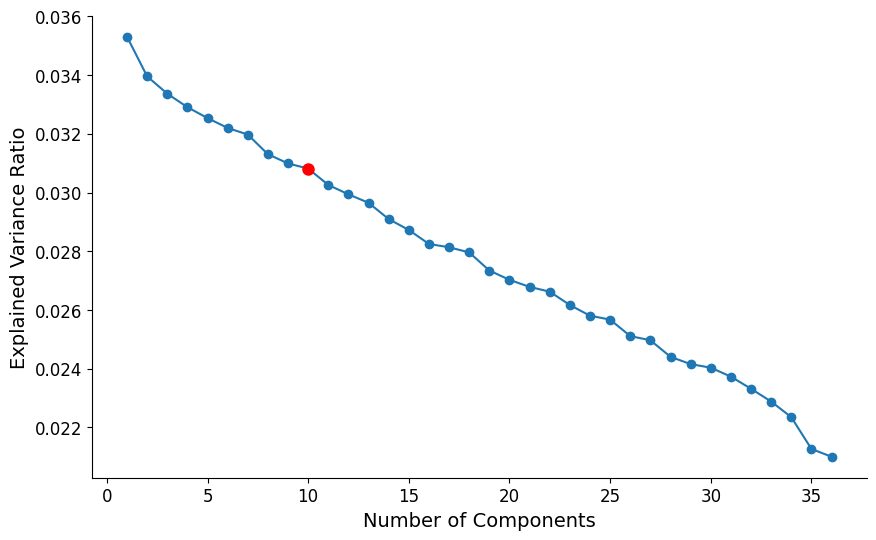

In [34]:
from sklearn.decomposition import PCA

# Run PCA
# Center the data by removing the mean from each column
fc_concat = fc_concat - np.mean(fc_concat, axis=0)

# Run PCA
pca = PCA()
pca.fit(fc_concat)

# Calculate the explained variance
explained_variance = pca.explained_variance_ratio_

# Generate the elbow plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='-')
ax.set_xlabel('Number of Components', fontsize=14)
ax.set_ylabel('Explained Variance Ratio', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#Define the number of components to keep
n_comp = 10

# Highlight the points corresponding to number of components we keep in red
ax.plot(n_comp, explained_variance[n_comp-1], marker='o', markersize=8, color='red')

plt.show()

We are using the elbow plot to decide the number of principal components to keep.

## Reconstruct the FC with a limited number of components

After extracting the principal components, each FC matrix can be expressed as a linear combinations of the principal components plus a residual matrix.

In [35]:
print(pca.components_.shape)
# Project PC components back into each FC subject space
fc_projected = pca.transform(fc_concat)[:, :n_comp]
print(fc_projected.shape)
fc_reconstructed = np.dot(fc_projected, pca.components_[:n_comp, :]) + np.mean(fc_concat, axis=0)
print(fc_reconstructed.shape)

(36, 36)
(2080, 10)
(2080, 36)


## Compute the residual matrix

(2080, 36)


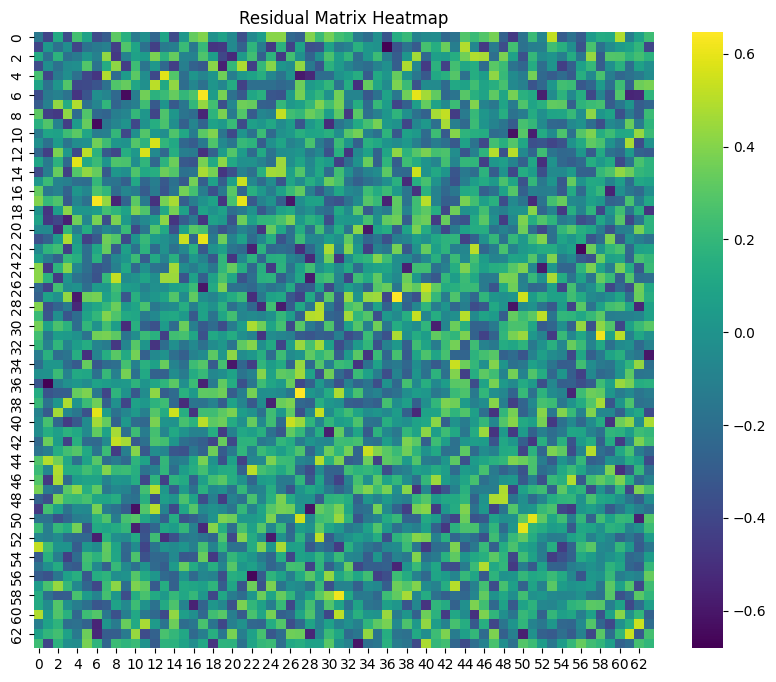

In [36]:
# Calculate the residuals as the difference between the full and reconstructed FC matrices
residuals = fc_concat - fc_reconstructed
print(residuals.shape)

# Function to reconstruct the full matrix from the upper triangle
def reconstruct_full_matrix(upper_triangle, size):
    full_matrix = np.zeros((size, size))
    upper_indices = np.triu_indices(size)
    full_matrix[upper_indices] = upper_triangle
    full_matrix = full_matrix + full_matrix.T - np.diag(np.diag(full_matrix))
    return full_matrix


# Assuming the size of the original FC matrix is 64x64
size = 64
residual = reconstruct_full_matrix(residuals[:,0], size)


# Plot the residual matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(residual, cmap='viridis')
plt.title('Residual Matrix Heatmap')
plt.show()

(2080, 36)


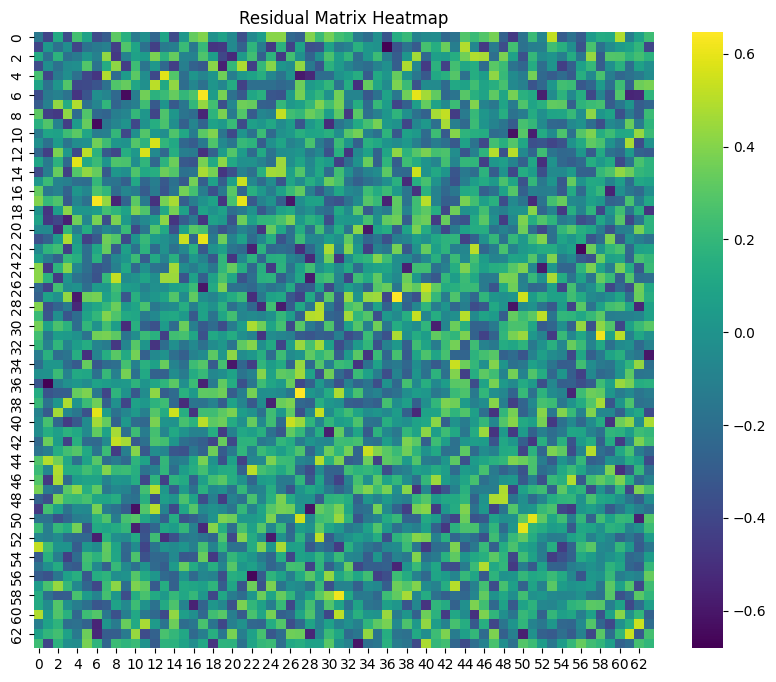

In [37]:
import numpy as np
from sklearn.decomposition import PCA

# Project the data onto the residual components (from n_comp + 1 onwards)
residuals_frompc = pca.transform(fc_concat)[:, n_comp:]

# Reconstruct the data using the residual components
residuals_frompc = np.dot(residuals_frompc, pca.components_[n_comp:, :]) + np.mean(fc_concat, axis=0)

# Print the shape of the reconstructed data
print(residuals_frompc.shape)

# Assuming the size of the original FC matrix is 64x64
size = 64
residual_frompc = reconstruct_full_matrix(residuals_frompc[:,0], size)


# Plot the residual matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(residual_frompc, cmap='viridis')
plt.title('Residual Matrix Heatmap')
plt.show()
